The purpose of this notebook is to study the relationship between the Gini index and different economic indicators such as:
* Current account balance (% of GDP)
* Inflation, consumer prices (annual %)
* Tax revenue (% of GDP)
* Time required to start a business (days)
* Unemployment, total (% of total labor force)

In [113]:
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import statsmodels.api as sm

### Load and explore data

Load WDI data from SQL

In [114]:
conn = sqlite3.connect(r'C:\Users\Irina\Documents\Python Scripts\input\world-development-indicators\database.sqlite')

In [115]:
#conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')

In [141]:
query_str = """SELECT * from Indicators 
               WHERE Year BETWEEN 2005 AND 2010 AND 
               IndicatorCode IN ('SL.UEM.TOTL.NE.ZS','FP.CPI.TOTL.ZG','BN.CAB.XOKA.GD.ZS',
                                     'IC.REG.DURS','GC.TAX.TOTL.GD.ZS', 'SI.POV.GINI') 
            """

In [142]:
wdi_df = pd.read_sql_query(query_str, conn)

Count how many values we have for each indicator (across countries and years)

In [143]:
wdi_df.groupby('IndicatorName').count()

,CountryName,CountryCode,IndicatorCode,Year,Value
IndicatorName,,,,,
Current account balance (% of GDP),1041,1041,1041,1041,1041
GINI index (World Bank estimate),450,450,450,450,450
"Inflation, consumer prices (annual %)",1223,1223,1223,1223,1223
Tax revenue (% of GDP),909,909,909,909,909
Time required to start a business (days),1207,1207,1207,1207,1207
"Unemployment, total (% of total labor force) (national estimate)",858,858,858,858,858


See top rows

In [145]:
wdi_df.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Albania,ALB,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,2005,-7.004620
1,Algeria,DZA,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,2005,20.523608
2,Angola,AGO,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,2005,13.897092
3,Antigua and Barbuda,ATG,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,2005,-17.194438
4,Argentina,ARG,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,2005,2.388325


In [146]:
wdi_df.shape

(5688, 6)

Pivot dataframe so the indicators are on columns

In [147]:
wdi_df_piv = wdi_df.pivot_table(index=['CountryCode','Year'], 
                                columns=['IndicatorName'], 
                                values=['Value']).reset_index()

In [148]:
wdi_df_piv.shape

(1383, 8)

In [149]:
wdi_df_piv.columns = ['CountryCode','Year'] + list(wdi_df_piv.columns.droplevel())[2:]

In [150]:
wdi_df_piv.head()

,CountryCode,Year,Current account balance (% of GDP),GINI index (World Bank estimate),"Inflation, consumer prices (annual %)",Tax revenue (% of GDP),Time required to start a business (days),"Unemployment, total (% of total labor force) (national estimate)"
0,ABW,2005,4.502927,NaN,3.395625,NaN,NaN,NaN
1,ABW,2006,12.825064,NaN,3.608711,NaN,NaN,NaN
2,ABW,2007,9.843563,NaN,5.391203,NaN,NaN,5.7
3,ABW,2008,0.004002,NaN,8.957732,NaN,NaN,NaN
4,ABW,2009,6.869971,NaN,-2.136372,NaN,NaN,NaN


In [151]:
wdi_df_piv.columns

Index(['CountryCode', 'Year', 'Current account balance (% of GDP)',
       'GINI index (World Bank estimate)',
       'Inflation, consumer prices (annual %)', 'Tax revenue (% of GDP)',
       'Time required to start a business (days)',
       'Unemployment, total (% of total labor force) (national estimate)'],
      dtype='object')

Rearrange and rename columns

In [152]:
wdi_df_mod = wdi_df_piv[['CountryCode','GINI index (World Bank estimate)','Year', 
                        'Current account balance (% of GDP)',                       
                        'Inflation, consumer prices (annual %)', 'Tax revenue (% of GDP)',
                        'Time required to start a business (days)',
                        'Unemployment, total (% of total labor force) (national estimate)']]

In [153]:
wdi_df_mod.columns = ['CountryCode','Gini','Year', 
                        'CurAcc',
                        'Inflat', 
                        'TaxRev',
                        'BusDay',
                        'Unempl']

Describe data

In [154]:
wdi_df_mod.describe()

,Gini,Year,CurAcc,Inflat,TaxRev,BusDay,Unempl
count,450.000000,1383.000000,1041.000000,1223.000000,909.000000,1207.000000,858.000000
mean,37.632156,2007.503254,-2.377415,5.908698,17.099347,41.140166,8.545412
std,8.992302,1.710133,18.804218,5.549105,8.268267,57.696146,6.173639
min,16.640000,2005.000000,-62.384092,-10.067493,0.021695,0.500000,0.100000
25%,30.627500,2006.000000,-9.416289,2.449445,12.251960,16.000000,4.800000
50%,34.805000,2008.000000,-3.706768,4.443655,15.733344,30.000000,7.300000
75%,42.962500,2009.000000,2.266803,7.980277,20.939107,47.888889,9.930354
max,64.790000,2010.000000,291.317976,53.230963,65.902923,697.000000,47.500000


Count missing data

In [155]:
wdi_df_mod.groupby(['Year']).count()

,CountryCode,Gini,CurAcc,Inflat,TaxRev,BusDay,Unempl
Year,,,,,,,
2005,230,76,170,199,142,195,142
2006,231,72,173,202,147,199,138
2007,230,74,175,203,152,202,143
2008,229,74,174,204,156,203,141
2009,231,76,175,207,158,204,143
2010,232,78,174,208,154,204,151


In [156]:
wdi_corr = wdi_df_mod.iloc[:,1:].corr()
mask = np.zeros(wdi_corr.shape, dtype=bool)
mask[np.tril_indices(len(mask))] = True

In [157]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

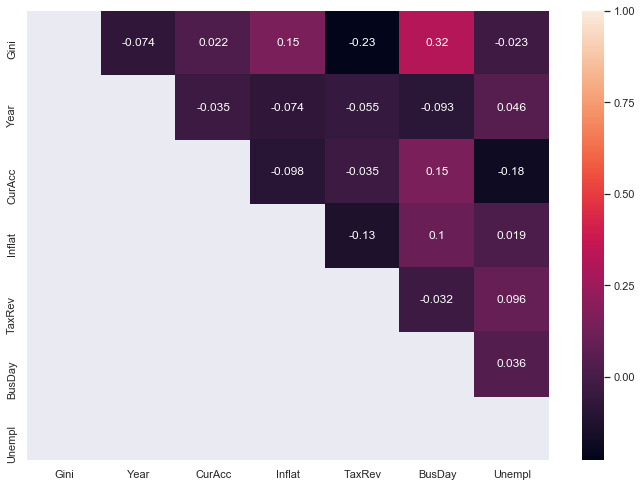

In [158]:
sns.heatmap(wdi_corr, annot = True, mask = mask);

In [164]:
sns.set(font_scale=1)

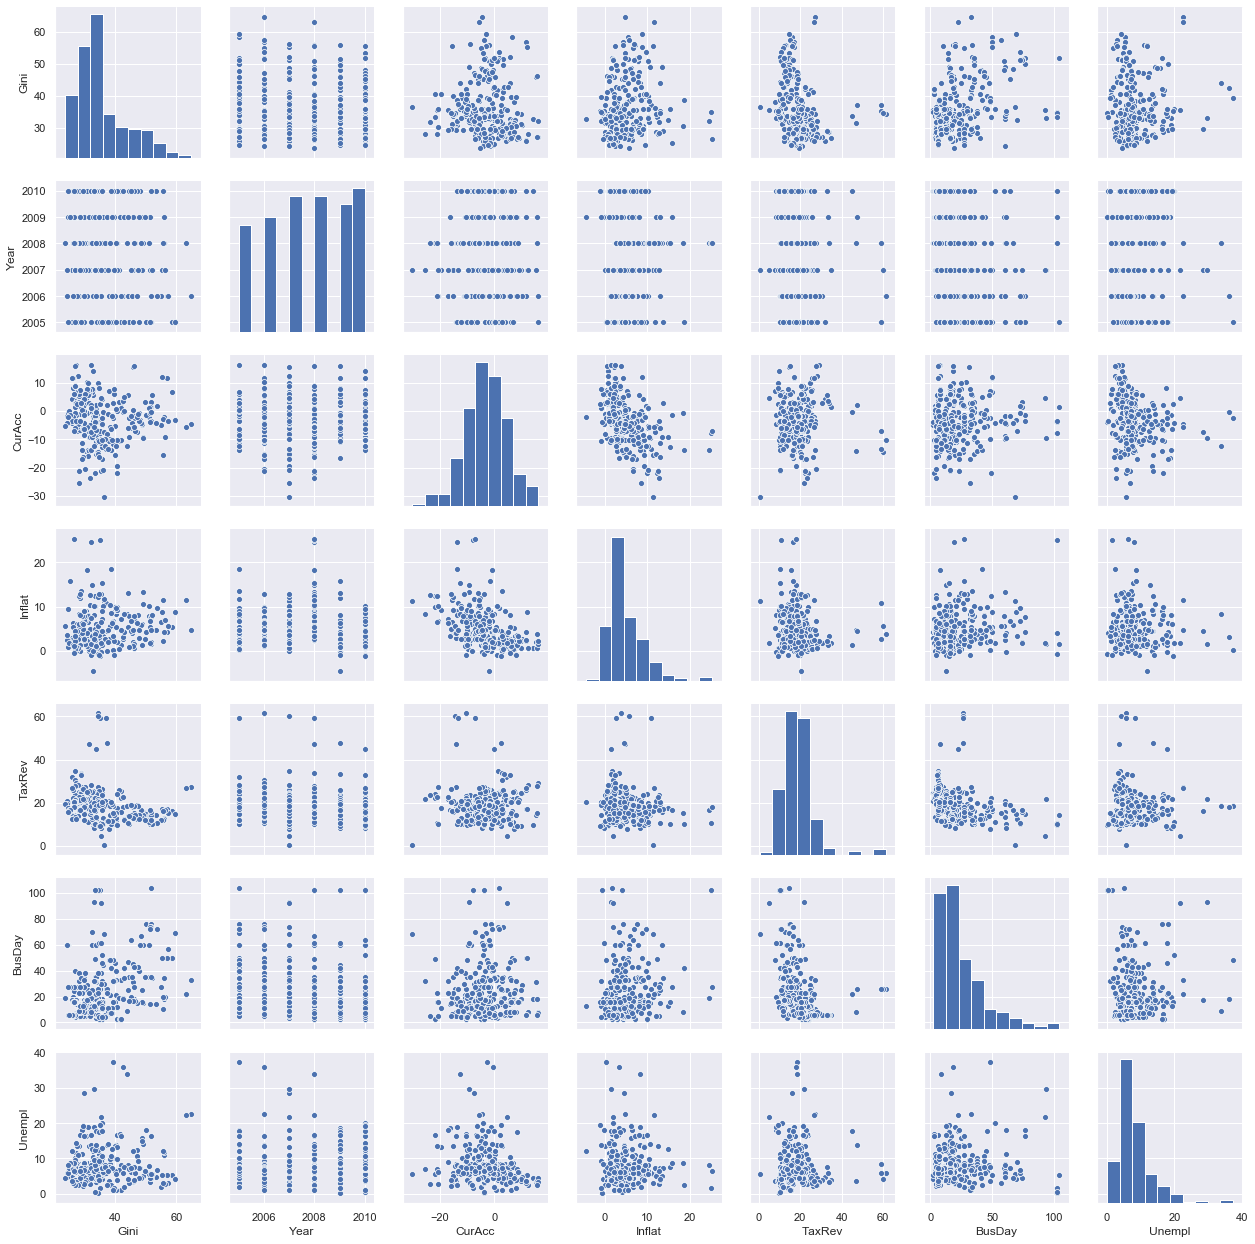

In [165]:
sns.pairplot(wdi_df_mod);

In [161]:
wdi_df_mod.dropna(inplace=True)

C:\Users\Irina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Models

No data transformation

In [199]:
X = wdi_df_mod.iloc[:,2:]
y = wdi_df_mod.iloc[:,1]
X =  sm.add_constant(X)
# Note the difference in argument order
olsmod = sm.OLS(y, X).fit()
ypred = olsmod.predict(X) # make the predictions by the model

# Print out the statistics
olsmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gini   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     10.19
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           3.18e-10
Time:                        22:44:59   Log-Likelihood:                -1007.2
No. Observations:                 293   AIC:                             2028.
Df Residuals:                     286   BIC:                             2054.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        215.7152    561.387      0.384      0.701    -889.259    1320.689
Year          -0.0910      0.279     -0.326      0.745      -0.641       0.459
CurAcc         0.0412      0.066      0.621      0.535      -0.089       0.172
Inflat         0.2546      0.122      2.089      0.038       0.015       0.494
TaxRev        -0.1266      0.061     -2.075      0.039      -0.247      -0.007
BusDay         0.1331      0.025      5.406      0.000       0.085       0.182
Unempl         0.1124      0.086      1.312      0.191      -0.056       0.281
==============================================================================
Omnibus:                       30.701   Durbin-Watson:                   0.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.883
Skew:                           0.786   Prob(JB):                     5.94e-09
Kurtosis:                       3.795   Cond. No.                     2.53e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual analysis

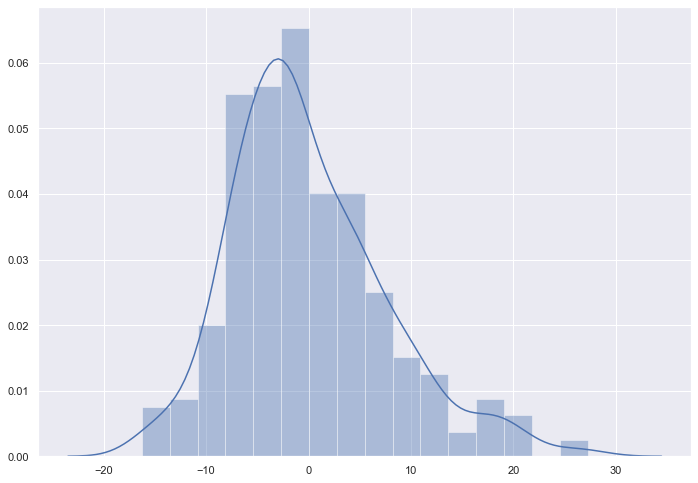

In [200]:
sns.distplot(y - ypred);

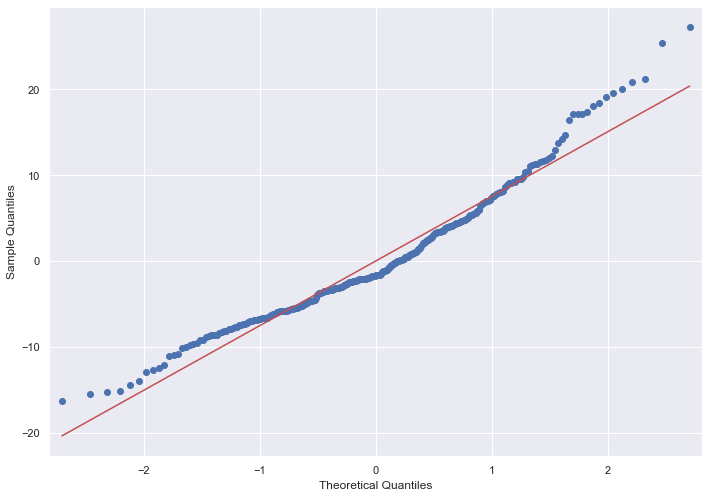

In [201]:
sm.qqplot(y - ypred, line='s');

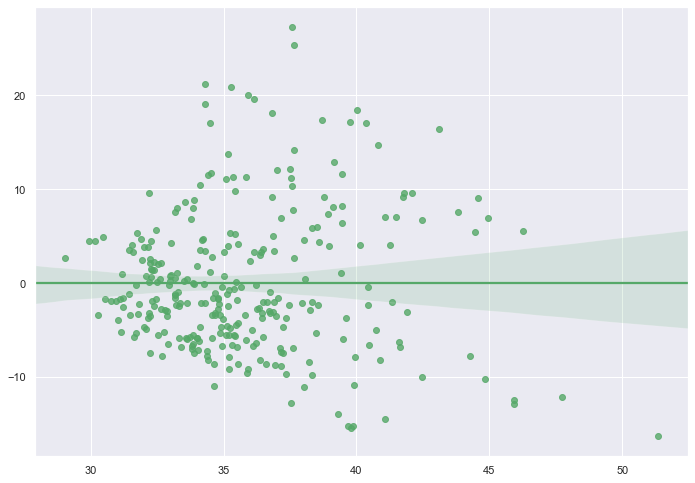

In [202]:
sns.regplot(ypred, y - ypred, color="g");